In [1]:
import torch
from torch import nn, optim
from kilroyplot.plot import plt

In [2]:
n_choices = 100

In [3]:
rewards = torch.randn(n_choices)
rewards

tensor([ 0.3516, -0.5698, -1.5341, -0.2287,  0.8834, -1.7092, -0.2216,  0.0209,
        -0.7699,  0.7392, -0.5808,  0.9290, -1.0333, -0.5667, -0.6064, -0.5680,
         0.5515,  0.7227,  0.7101,  0.6245,  0.1484,  0.6070,  0.8854,  0.7033,
         0.2384,  0.4557,  0.6873, -1.2642,  1.5618,  0.7057,  0.8360, -1.0342,
        -0.1215, -0.4568, -2.5261, -0.5386, -1.3705,  1.4743,  0.0835, -0.5058,
         0.7484,  0.9499, -1.4674,  0.4384, -1.5140,  0.2631, -1.2553,  0.3949,
        -0.4034,  1.0280,  1.9396,  1.3178,  0.6753,  1.4168, -0.2561, -0.9241,
         0.0385, -0.2639,  0.0709,  0.3322,  0.9161, -0.7864,  1.1276,  0.2410,
         1.5662, -0.6126, -0.1690, -0.3868, -1.1182,  0.9935,  0.0663,  1.6134,
        -0.1706,  0.2972, -2.6203, -0.2355,  0.5731,  0.7491,  2.1983, -0.0574,
         0.2461, -0.3147, -0.5989,  1.4289, -1.9027,  0.2146,  1.1101,  1.5343,
        -1.0674, -0.2294,  1.8732, -0.1501,  1.9080, -0.3291, -0.9152,  0.6527,
        -0.9316, -0.7105, -0.3025,  1.52

In [4]:
class Actor(nn.Module):
    def __init__(self, n_out, n_hidden=10):
        super().__init__()
        self.x = torch.ones(1)
        self.layers = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(-1)
        )

    def forward(self):
        return self.layers(self.x)

In [5]:
class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.x = torch.ones(n_hidden)
        self.layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class Sampler:
    def __init__(self, weights):
        self.sampler = torch.distributions.categorical.Categorical(weights)
        
    def sample(self, n=1):
        return  self.sampler.sample((n,))

In [7]:
class OneHotEncoder:
    def __init__(self, n):
        self.n = n
        
    def encode(self, x):
        return nn.functional.one_hot(x, self.n)

In [8]:
actor = Actor(n_choices)
critic = Critic(n_choices)

In [9]:
encoder = OneHotEncoder(n_choices)

In [10]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.005)

In [11]:
criterion = nn.MSELoss()

In [12]:
epochs = 1000
actor_iters = 10000
critic_iters = 10

In [13]:
critic_losses = []
actor_rewards = []

for _ in range(epochs):
    critic_optimizer.zero_grad()
    choice = Sampler(actor()).sample(critic_iters)
    x = encoder.encode(choice)
    pred_reward = critic(x.float())
    real_reward = rewards[choice].unsqueeze(-1)
    loss = criterion(pred_reward, real_reward)
    loss.backward()
    critic_optimizer.step()
    
    critic_losses.append(loss.item())
    
    actor_optimizer.zero_grad()
    probs = actor()
    choice = Sampler(probs).sample(actor_iters)
    x = encoder.encode(choice)
    reward = critic(x.float())
    loss = -(reward * torch.log(probs[choice].unsqueeze(-1))).mean()
    loss.backward()
    actor_optimizer.step()
    
    actor_rewards.append(reward.mean().item())

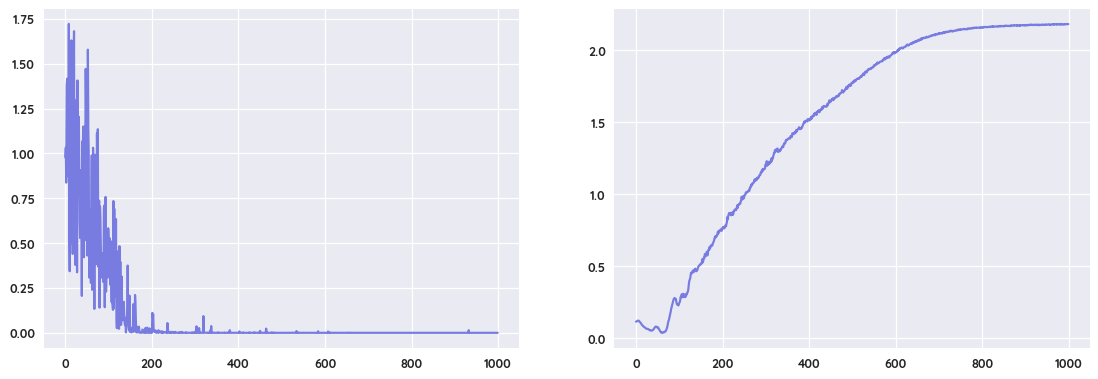

In [14]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(critic_losses)
axs[1].plot(actor_rewards)

<BarContainer object of 100 artists>

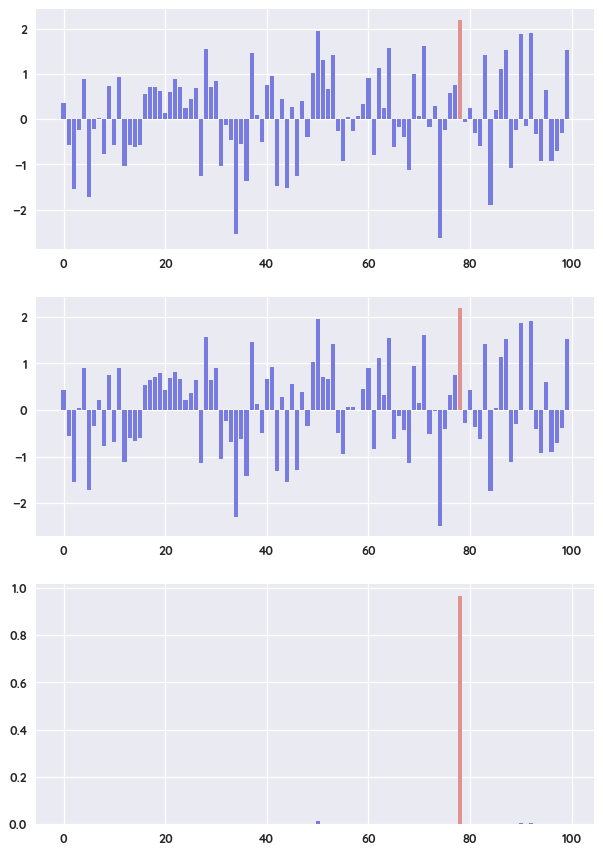

In [15]:
color=['C1' if i == actor().argmax() else 'C0' for i in range(n_choices)]
_, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].bar(range(n_choices), rewards, color=color)
axs[1].bar(range(n_choices), critic(encoder.encode(torch.arange(n_choices)).float()).flatten().detach().numpy(), color=color)
axs[2].bar(range(n_choices), actor().detach().numpy(), color=color)